In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [152]:
build_ener_df = pd.read_feather("build_ener_df.ftr")
build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

In [153]:
build_ener_df_enstr_drop = build_ener_df.copy()
build_ener_df_enstr_dflt = build_ener_df.copy()
build_ener_df_enstr_sub_imposs = build_ener_df.copy()
build_ener_df_enstr_oneht = build_ener_df.copy()
build_ener_df_enstr_intrp = build_ener_df.copy()
build_ener_df_no_enstr = build_ener_df.copy()

build_ener_df_enstr_drop = build_ener_df_enstr_drop.loc[
    ~build_ener_df_enstr_drop["ENERGYSTARScore"].isna()
].astype({"ENERGYSTARScore": "int"})
build_ener_df_enstr_dflt["ENERGYSTARScore"] = (
    build_ener_df_enstr_dflt["ENERGYSTARScore"]
    .fillna(
        int(
            build_ener_df_enstr_drop.astype({"ENERGYSTARScore": int})[
                "ENERGYSTARScore"
            ].median()
        )
    )
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_sub_imposs["ENERGYSTARScore"] = (
    build_ener_df_enstr_sub_imposs["ENERGYSTARScore"]
    .fillna(-100)
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_oneht = pd.concat(
    [
        build_ener_df_enstr_oneht,
        pd.get_dummies(
            build_ener_df_enstr_oneht.ENERGYSTARScore, prefix="ENERGYSTARScore"
        ),
    ],
    axis=1,
).drop("ENERGYSTARScore", axis=1)
# enstr_ohe_cols = [f"ENERGYSTARScore_{i}" for i in range(1, 101)]
build_ener_df_no_enstr = build_ener_df_no_enstr.drop("ENERGYSTARScore", axis=1)


In [154]:
imputation_df = build_ener_df_enstr_intrp.copy()

for col in ["PrimaryPropertyType", "LargestPropertyUseType"]:
    imputation_df = pd.concat(
        [
            imputation_df,
            pd.get_dummies(imputation_df[col], prefix=col),
        ],
        axis=1,
    ).drop(col, axis=1)

prop_type_cols = [
    x for x in imputation_df.columns.to_list() if x.startswith("PrimaryPropertyType")
]
prop_use_cols = [
    x for x in imputation_df.columns.to_list() if x.startswith("LargestPropertyUseType")
]
imput_cols = (
    [
        "Latitude",
        "Longitude",
        "YearBuilt",
        "PropertyGFATotal",
        "PropertyGFABuilding(s)",
        "LargestPropertyUseTypeGFA",
        "ENERGYSTARScore",
        "SiteEnergyUseWN(kBtu)",
        "SourceEnergyUseWN(kBtu)",
        "SteamUse(kBtu)",
        "Electricity(kBtu)",
        "NaturalGas(kBtu)",
        "TotalGHGEmissions",
    ]
    + prop_type_cols
    + prop_use_cols
)
it_imp = IterativeImputer(
    sample_posterior=True, min_value=1, max_value=100, random_state=0
)
build_ener_df_enstr_intrp["ENERGYSTARScore"] = (
    pd.DataFrame(it_imp.fit_transform(imputation_df[imput_cols]), columns=imput_cols)
    .round()
    .astype({"ENERGYSTARScore": "int"})["ENERGYSTARScore"]
    .to_list()
)

build_ener_df_enstr_intrp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

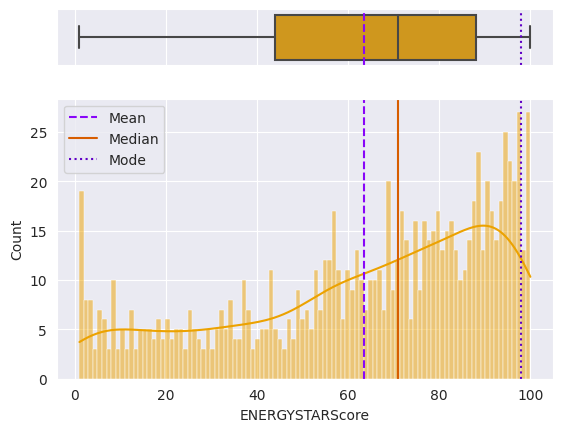

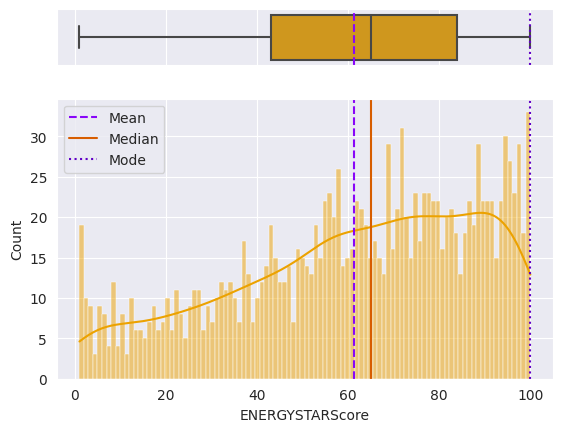

In [155]:
for df in [build_ener_df_enstr_drop, build_ener_df_enstr_intrp]:
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)}
    )
    mean = df["ENERGYSTARScore"].mean()
    median = df["ENERGYSTARScore"].median()
    mode = df["ENERGYSTARScore"].mode().values[0]
    theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    sns.set_palette("gnuplot")
    sns.set_style("darkgrid")
    sns.boxplot(data=df, x="ENERGYSTARScore", ax=ax_box, color=theme_clrs[5])
    ax_box.axvline(mean, color=theme_clrs[1], linestyle="--")
    ax_box.axvline(mode, color=theme_clrs[0], linestyle=":")
    sns.histplot(
        data=df,
        x="ENERGYSTARScore",
        ax=ax_hist,
        bins=100,
        kde=True,
        color=theme_clrs[5],
    )
    ax_hist.axvline(mean, color=theme_clrs[1], linestyle="--", label="Mean")
    ax_hist.axvline(median, color=theme_clrs[4], linestyle="-", label="Median")
    ax_hist.axvline(mode, color=theme_clrs[0], linestyle=":", label="Mode")
    ax_hist.legend()
    ax_box.set(xlabel="")
    plt.show()


In [163]:
contin_feats = [
    # "Latitude",
    # "Longitude",
    "YearBuilt",
    # "NumberofBuildings",
    # "NumberofFloors",
    # "PropertyGFATotal",
    # "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    # "SecondLargestPropertyUseTypeGFA",
    # "ThirdLargestPropertyUseTypeGFA",
    "SiteEnergyUseWN(kBtu)",
    "SourceEnergyUseWN(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)",
]
categ_feats = [
    # "BuildingType",
    "PrimaryPropertyType",
    # "ZipCode",
    # "CouncilDistrictCode",
    # "Neighborhood",
    "LargestPropertyUseType",
    # "SecondLargestPropertyUseType",
    # "ThirdLargestPropertyUseType",
]
mm_scaler = MinMaxScaler(feature_range=(0, 1))


def normalize_contin(df, scale_enstr=False):
    feats = contin_feats.copy()

    if scale_enstr:
        feats += ["ENERGYSTARScore"]

    with pd.option_context("mode.chained_assignment", None):
        df[feats] = mm_scaler.fit_transform(df[feats].to_numpy())

    return df


def one_hot_categs(df):
    for feat in categ_feats:
        df = pd.concat(
            [
                df,
                pd.get_dummies(df[feat], prefix=feat),
            ],
            axis=1,
        ).drop(feat, axis=1)

    return df


build_ener_df_enstr_drop_data = build_ener_df_enstr_drop[
    contin_feats + categ_feats + ["ENERGYSTARScore"]
].copy()
build_ener_df_enstr_drop_target = build_ener_df_enstr_drop["TotalGHGEmissions"].copy()
build_ener_df_enstr_dflt_data = build_ener_df_enstr_dflt[
    contin_feats + categ_feats + ["ENERGYSTARScore"]
].copy()
build_ener_df_enstr_dflt_target = build_ener_df_enstr_dflt["TotalGHGEmissions"].copy()
build_ener_df_enstr_sub_imposs_data = build_ener_df_enstr_sub_imposs[
    contin_feats + categ_feats + ["ENERGYSTARScore"]
].copy()
build_ener_df_enstr_sub_imposs_target = build_ener_df_enstr_sub_imposs[
    "TotalGHGEmissions"
].copy()
build_ener_df_enstr_oneht_data = build_ener_df_enstr_oneht[
    contin_feats + categ_feats
].copy()
build_ener_df_enstr_oneht_target = build_ener_df_enstr_oneht["TotalGHGEmissions"].copy()
build_ener_df_enstr_intrp_data = build_ener_df_enstr_intrp[
    contin_feats + categ_feats + ["ENERGYSTARScore"]
].copy()
build_ener_df_enstr_intrp_target = build_ener_df_enstr_intrp["TotalGHGEmissions"].copy()
build_ener_df_no_enstr_data = build_ener_df_no_enstr[contin_feats + categ_feats].copy()
build_ener_df_no_enstr_target = build_ener_df_no_enstr["TotalGHGEmissions"].copy()
build_ener_df_enstr_drop_data = normalize_contin(
    one_hot_categs(build_ener_df_enstr_drop_data), scale_enstr=True
)
build_ener_df_enstr_dflt_data = normalize_contin(
    one_hot_categs(build_ener_df_enstr_dflt_data), scale_enstr=True
)
build_ener_df_enstr_sub_imposs_data = normalize_contin(
    one_hot_categs(build_ener_df_enstr_sub_imposs_data), scale_enstr=True
)
build_ener_df_enstr_intrp_data = normalize_contin(
    one_hot_categs(build_ener_df_enstr_intrp_data), scale_enstr=True
)
build_ener_df_enstr_oneht_data = normalize_contin(
    one_hot_categs(build_ener_df_enstr_oneht_data)
)
build_ener_df_no_enstr_data = normalize_contin(
    one_hot_categs(build_ener_df_no_enstr_data)
)
data_and_targets = [
    [
        "ENERGYSTARScore NaNs dropped",
        build_ener_df_enstr_drop_data,
        build_ener_df_enstr_drop_target,
    ],
    [
        "ENERGYSTARScore NaNs replaced by median",
        build_ener_df_enstr_dflt_data,
        build_ener_df_enstr_dflt_target,
    ],
    [
        "ENERGYSTARScore NaNs replaced by negative scores",
        build_ener_df_enstr_sub_imposs_data,
        build_ener_df_enstr_sub_imposs_target,
    ],
    [
        "ENERGYSTARScore NaNs imputed",
        build_ener_df_enstr_intrp_data,
        build_ener_df_enstr_intrp_target,
    ],
    [
        "ENERGYSTARScore with one-hot encoding",
        build_ener_df_enstr_oneht_data,
        build_ener_df_enstr_oneht_target,
    ],
    [
        "No ENERGYSTARScore used",
        build_ener_df_no_enstr_data,
        build_ener_df_no_enstr_target,
    ],
]
build_ener_df_enstr_drop_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 1487
Columns: 177 entries, YearBuilt to ThirdLargestPropertyUseType_Worship Facility
dtypes: float64(15), uint8(162)
memory usage: 274.4 KB


In [164]:
for datum_and_target in data_and_targets:
    X_train, X_test, y_train, y_test = train_test_split(
        datum_and_target[1].to_numpy(), datum_and_target[2].to_numpy(), test_size=0.2
    )
    regr_model = LinearRegression()

    regr_model.fit(X_train, y_train)
    print(f"{datum_and_target[0]}\n{regr_model.score(X_test, y_test)}")


ENERGYSTARScore NaNs dropped
-7213080455122.093
ENERGYSTARScore NaNs replaced by median
-5990325927364.47
ENERGYSTARScore NaNs replaced by negative scores
-289578160934.0302
ENERGYSTARScore NaNs imputed
-793291592574.9896
ENERGYSTARScore with one-hot encoding
-367537907298.9709
No ENERGYSTARScore used
-1915236452.4727464
